In [133]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../data/" directory

# Load the train data
train_values_file_path = '../data/train-set-values.csv'
train_values = pd.read_csv(train_values_file_path)
X = train_values.copy()

train_labels_file_path = '../data/train-set-labels.csv'
train_labels = pd.read_csv(train_labels_file_path)
y = train_labels.copy()

X_y = pd.concat([X.set_index('id'),y.set_index('id')], axis=1, join='inner').reset_index()

# Load the test data
test_file_path = '../data/test-set-values.csv'
test_values = pd.read_csv(test_file_path)
X_test = test_values.copy()

## pre-processing 

In the pre-pcessing step, we'll try to convert some of the useful features identified in EDA, into a form that can be fed to a ML model. We'll store that set of features in a data frame called `features_X` for 'train data' and `features_X_test` for 'test data'.

#### `funder`

As observed in EDA, `funder` has 1897 unique values (Some of which are due to spelling errors, capitalization errors, and data entry errors)

Lets first convert everything to lowecase to try and minimize capitalization errors if any

In [134]:
funder = X['funder'].astype(str)
funder = funder.str.lower()

funder_test = X_test['funder'].astype(str)
funder_test = funder_test.str.lower()

Then lets identify the values which are most likely to be the same and then replace similar values with one value. Function `replace_similar_categories` is written for this purpose. It uses the FuzzyWuzzy Package to calculate string similarity using Levenshtein distance ratio of similarity.

ref: https://www.datacamp.com/community/tutorials/fuzzy-string-python
 

In [135]:
from fuzzywuzzy import fuzz
from collections import defaultdict

def get_similar_categories(sr, threshold):
    replacements_dict = defaultdict(lambda: "other")
    unique_list = []

    for category in sr.unique():    
        is_unique = True
        replacements_dict[category] = category
        for unique_category in unique_list:        
            if (fuzz.ratio(category, unique_category) > threshold):
                replacements_dict[category] = unique_category
                is_unique = False
    #             print (category + " replaced by " + unique_category)
                break            
        if(is_unique):
            unique_list.append(category)    
    
    return replacements_dict

In [136]:
funder_similar_category_replacements = get_similar_categories(funder, 85)

In [137]:
funder = funder.map(funder_similar_category_replacements)
funder_test = funder_test.map(funder_similar_category_replacements)

Then lets replace the categories that occur less than 2% of the time with 'other'. Number 2% was empirically determined as a number that yields a reasonable number of categories.  

In [138]:
def get_less_occuring_categories(sr, threshold):
    val_counts = sr.value_counts(normalize=True)
    replacements_dict = defaultdict(lambda: "other")

    for category in sr.unique():
        if(val_counts.at[category] < threshold):
            replacements_dict[category] = 'other'
        else:
            replacements_dict[category] = category
    return replacements_dict        

In [139]:
funder_less_occuring_category_replacements = get_less_occuring_categories(funder, 0.02)

In [140]:
funder = funder.map(funder_less_occuring_category_replacements)
funder_test = funder_test.map(funder_less_occuring_category_replacements)

In [141]:
len(funder.unique())

9

In [142]:
features_X = funder.to_frame()
features_X_test = funder_test.to_frame()

#### `installer`

Since `installer` is very similar to `funder` in nature, we'll use the same preprocessing steps to `installer` as well.

In [143]:
installer = X['installer'].astype(str)
installer = installer.str.lower()

installer_test = X_test['installer'].astype(str)
installer_test = installer_test.str.lower()

installer_similar_category_replacements = get_similar_categories(installer, 85)

installer = installer.map(installer_similar_category_replacements)
installer_test = installer_test.map(installer_similar_category_replacements)

installer_less_occuring_category_replacements = get_less_occuring_categories(installer, 0.02)

installer = installer.map(installer_less_occuring_category_replacements)
installer_test = installer_test.map(installer_less_occuring_category_replacements)

In [144]:
len(installer.unique())

7

In [145]:
features_X = features_X.merge(installer, left_index=True, right_index=True)
features_X_test = features_X_test.merge(installer_test, left_index=True, right_index=True)
features_X

,funder,installer
0,other,other
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
59395,other,other
59396,other,other
59397,nan,nan
59398,other,other


#### `basin`

We can directly use `basin` as it contains only 9 categories.

In [146]:
features_X = features_X.merge(X['basin'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['basin'], left_index=True, right_index=True)
features_X

,funder,installer,basin
0,other,other,Lake Nyasa
1,other,other,Lake Victoria
2,other,other,Pangani
3,other,other,Ruvuma / Southern Coast
4,other,other,Lake Victoria
...,...,...,...
59395,other,other,Pangani
59396,other,other,Rufiji
59397,nan,nan,Rufiji
59398,other,other,Rufiji


#### Features related to the Geographical location

We'll consider `gps_height`, `longitude`, `latitude`, and, `region` to represent Geographical data. We'll first handle outliers

In [147]:
num_geo_features = X[['gps_height', 'longitude', 'latitude', 'region']]

Q1 = num_geo_features.quantile(0.25)
Q3 = num_geo_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

gps_height    1319.250000
longitude        4.088039
latitude         5.214466
dtype: float64


We'll replace outliers with the median value of their region. 

In [148]:
new_num_geo_features = pd.DataFrame()

for feature in ['gps_height', 'longitude', 'latitude']:
    lower_whisker = Q1[feature] - 1.5 * IQR[feature]
    higher_whisker = Q3[feature] + 1.5 * IQR[feature] 
    
    new_num_geo_features[feature] = num_geo_features[feature].apply(lambda x: np.nan if (x < lower_whisker or x > higher_whisker) else x)

In [149]:
new_num_geo_features['region'] = num_geo_features['region']

In [150]:
for feature in ['gps_height', 'longitude', 'latitude']:
    new_num_geo_features[feature].fillna(new_num_geo_features.groupby('region')[feature].transform('median'))

Applying the same for the test data set

In [151]:
num_geo_features_test = X[['gps_height', 'longitude', 'latitude', 'region']]

new_num_geo_features_test = pd.DataFrame()

for feature in ['gps_height', 'longitude', 'latitude']:
    lower_whisker = Q1[feature] - 1.5 * IQR[feature]
    higher_whisker = Q3[feature] + 1.5 * IQR[feature] 
    
    new_num_geo_features_test[feature] = num_geo_features_test[feature].apply(lambda x: np.nan if (x < lower_whisker or x > higher_whisker) else x)
    
new_num_geo_features_test['region'] = num_geo_features_test['region']

for feature in ['gps_height', 'longitude', 'latitude']:
    new_num_geo_features_test[feature].fillna(new_num_geo_features.groupby('region')[feature].transform('median'))

In [152]:
features_X = features_X.merge(new_num_geo_features, left_index=True, right_index=True)
features_X_test = features_X_test.merge(new_num_geo_features_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara
2,other,other,Pangani,686,37.460664,-3.821329,Manyara
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera
...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma


#### Feature related to Operation and Management

Out of the similar features identified in EDA, lets choose `management` as the feature to represent operation and management information.

In [153]:
features_X = features_X.merge(X['management'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['management'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other
...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc


#### Feature related to Extraction Type

Out of the similar features identified in EDA, lets choose `extraction_type_class` as the feature to represent operation and management information.

In [154]:
features_X = features_X.merge(X['extraction_type_class'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['extraction_type_class'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity
...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump


#### Feature related to Cost

Out of the similar features identified in EDA, lets choose `payment` as the feature to represent cost type.

In [155]:
features_X = features_X.merge(X['payment'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['payment'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay
...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay


#### Feature related to Quality

Out of the similar features identified in EDA, lets choose `quality_group` as the feature to represent water quality.

In [156]:
features_X = features_X.merge(X['quality_group'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['quality_group'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good
...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good


#### Features related to Quantity

Out of the similar features identified in EDA, lets choose `quantity_group` as the feature to represent water quantity.

In [157]:
features_X = features_X.merge(X['quantity_group'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['quantity_group'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient


#### Features related to Source

Out of the similar features identified in EDA, lets choose `source_type` and `source_class` as the features to represent source.

In [158]:
features_X = features_X.merge(X['source_type'], left_index=True, right_index=True)
features_X = features_X.merge(X['source_class'], left_index=True, right_index=True)

features_X_test = features_X_test.merge(X_test['source_type'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['source_class'], left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater


#### Feature related to Waterpoint Type

Out of the similar features identified in EDA, lets choose `waterpoint_type` as the feature to represent waterpoint type.

In [159]:
features_X = features_X.merge(X['waterpoint_type'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['waterpoint_type'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump


#### Feature related to TSH

we'll consider the `amount_tsh` feature as well

In [160]:
features_X = features_X.merge(X['amount_tsh'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['amount_tsh'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0


#### Other Features

`public_meeting`

In [161]:
features_X = features_X.merge(X['public_meeting'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['public_meeting'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh,public_meeting
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0,True
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0,NaN
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0,True
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0,True
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0,True
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0,True
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0,True
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0,True


`permit`

In [162]:
features_X = features_X.merge(X['permit'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['permit'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh,public_meeting,permit
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0,True,False
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0,NaN,True
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0,True,True
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0,True,True
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0,True,True
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0,True,True
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0,True,False
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0,True,True


`population`

As seen in EDA, population also contained many outliers. Even the 25th quartile was 0. We'll try to replace those 0's with nan so that they will be later replaced with the mean value (in the pipeline)

In [163]:
population_df = pd.DataFrame()
population_df['population'] = X['population'].apply(lambda x: np.nan if x == 0 else x)

population_test_df = pd.DataFrame()
population_test_df['population'] = X_test['population'].apply(lambda x: np.nan if x == 0 else x)

population_df

,population
0,109.0
1,280.0
2,250.0
3,58.0
4,NaN
...,...
59395,125.0
59396,56.0
59397,NaN
59398,NaN


In [164]:
features_X = features_X.merge(population_df, left_index=True, right_index=True)
features_X_test = features_X_test.merge(population_test_df, left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh,public_meeting,permit,population
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0,True,False,109.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0,NaN,True,280.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0,True,True,250.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0,True,True,58.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0,True,True,125.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0,True,True,56.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0,True,False,NaN
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0,True,True,NaN


## Feature Engineering

#### New Feature to represent pump age

We'll add a new feature to represent pump age using the data given in `construction_year`.

In [165]:
pump_age = 2013 - X['construction_year']
pump_age.replace(2013, np.nan, inplace=True)
pump_age.name = "pump_age"

pump_age_test = 2013 - X['construction_year']
pump_age_test.replace(2013, np.nan, inplace=True)
pump_age_test.name = "pump_age"


In [166]:
features_X = features_X.merge(pump_age, left_index=True, right_index=True)
features_X_test = features_X_test.merge(pump_age_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type,amount_tsh,public_meeting,permit,population,pump_age
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,good,enough,spring,groundwater,communal standpipe,6000.0,True,False,109.0,14.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.0,NaN,True,280.0,3.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,good,enough,dam,surface,communal standpipe multiple,25.0,True,True,250.0,4.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,0.0,True,True,58.0,27.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0.0,True,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,good,enough,spring,groundwater,communal standpipe,10.0,True,True,125.0,14.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,good,enough,river/lake,surface,communal standpipe,4700.0,True,True,56.0,17.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,fluoride,enough,borehole,groundwater,hand pump,0.0,True,False,NaN,NaN
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,good,insufficient,shallow well,groundwater,hand pump,0.0,True,True,NaN,NaN


#### New Binary features to replace missing values in `public_meeting`, `permit`, and `population`

In [167]:
import math

new_bin_features = pd.DataFrame()

for feature in ['public_meeting', 'permit', 'population']:
    bin_feature_name = 'is_missing_' + feature
    new_bin_features[bin_feature_name] = features_X[feature].apply(lambda x: True if math.isnan(float(x)) else False)

new_bin_features

,is_missing_public_meeting,is_missing_permit,is_missing_population
0,False,False,False
1,True,False,False
2,False,False,False
3,False,False,False
4,False,False,True
...,...,...,...
59395,False,False,False
59396,False,False,False
59397,False,False,True
59398,False,False,True


In [168]:
new_bin_features_test = pd.DataFrame()

for feature in ['public_meeting', 'permit', 'population']:
    bin_feature_name = 'is_missing_' + feature
    new_bin_features_test[bin_feature_name] = features_X_test[feature].apply(lambda x: True if math.isnan(float(x)) else False)

new_bin_features_test

,is_missing_public_meeting,is_missing_permit,is_missing_population
0,False,False,False
1,False,False,False
2,False,True,False
3,True,False,False
4,True,False,False
...,...,...,...
14845,False,False,False
14846,False,False,False
14847,False,True,False
14848,False,False,False


In [169]:
features_X = features_X.merge(new_bin_features, left_index=True, right_index=True)
features_X_test = features_X_test.merge(new_bin_features_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,...,source_class,waterpoint_type,amount_tsh,public_meeting,permit,population,pump_age,is_missing_public_meeting,is_missing_permit,is_missing_population
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,...,groundwater,communal standpipe,6000.0,True,False,109.0,14.0,False,False,False
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,...,surface,communal standpipe,0.0,NaN,True,280.0,3.0,True,False,False
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,...,surface,communal standpipe multiple,25.0,True,True,250.0,4.0,False,False,False
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,...,groundwater,communal standpipe multiple,0.0,True,True,58.0,27.0,False,False,False
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,...,surface,communal standpipe,0.0,True,True,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,...,groundwater,communal standpipe,10.0,True,True,125.0,14.0,False,False,False
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,...,surface,communal standpipe,4700.0,True,True,56.0,17.0,False,False,False
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,...,groundwater,hand pump,0.0,True,False,NaN,NaN,False,False,True
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,...,groundwater,hand pump,0.0,True,True,NaN,NaN,False,False,True


## Feature Encoding

### Transformers for features

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import gen_features

#### Trasformer for Binary data

In [171]:
binary_cols = [col for col in features_X.columns if features_X[col].dtype == "bool"]
binary_cols_2d = [[col] for col in binary_cols]
print(binary_cols)

gen_binary = gen_features(
    columns = binary_cols_2d
)

['is_missing_public_meeting', 'is_missing_permit', 'is_missing_population']


#### Trasformer for Categorical data

In [172]:
categorical_cols = [col for col in features_X.columns if features_X[col].dtype == "object"]
categorical_cols_2d = [[col] for col in categorical_cols]
print(categorical_cols)

gen_categorical = gen_features(
    columns = categorical_cols_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "most_frequent"
        }
    ]
)

['funder', 'installer', 'basin', 'region', 'management', 'extraction_type_class', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'public_meeting', 'permit']


#### Trasformer for Numerical data

In [173]:
lat_long = ['latitude', 'longitude']
lat_long_2d = [[col] for col in lat_long]

gen_lat_long = gen_features(
    columns = lat_long_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "mean"
        },
        StandardScaler
    ]
)

In [174]:
numerical_cols = [col for col in features_X.columns if features_X[col].dtype in ['int64', 'float64']]
numerical_cols.remove('latitude')
numerical_cols.remove('longitude')

numerical_cols_2d = [[col] for col in numerical_cols]
print(numerical_cols)

gen_numerical = gen_features(
    columns = numerical_cols_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "mean"
        }
    ]
)

['gps_height', 'amount_tsh', 'population', 'pump_age']


### DFMapper

In [175]:
from sklearn_pandas import DataFrameMapper

feature_def = []
feature_def.extend(gen_binary)
feature_def.extend(gen_categorical)
feature_def.extend(gen_lat_long)
feature_def.extend(gen_numerical)

preprocess_mapper = DataFrameMapper(
    feature_def,
    input_df=True,
    df_out=True
)

feature_def

[(['is_missing_public_meeting'], None),
 (['is_missing_permit'], None),
 (['is_missing_population'], None),
 (['funder'], [SimpleImputer(strategy='most_frequent')], {}),
 (['installer'], [SimpleImputer(strategy='most_frequent')], {}),
 (['basin'], [SimpleImputer(strategy='most_frequent')], {}),
 (['region'], [SimpleImputer(strategy='most_frequent')], {}),
 (['management'], [SimpleImputer(strategy='most_frequent')], {}),
 (['extraction_type_class'], [SimpleImputer(strategy='most_frequent')], {}),
 (['payment'], [SimpleImputer(strategy='most_frequent')], {}),
 (['quality_group'], [SimpleImputer(strategy='most_frequent')], {}),
 (['quantity_group'], [SimpleImputer(strategy='most_frequent')], {}),
 (['source_type'], [SimpleImputer(strategy='most_frequent')], {}),
 (['source_class'], [SimpleImputer(strategy='most_frequent')], {}),
 (['waterpoint_type'], [SimpleImputer(strategy='most_frequent')], {}),
 (['public_meeting'], [SimpleImputer(strategy='most_frequent')], {}),
 (['permit'], [Simple

### Proprocessor

In [176]:
tranformed_df = preprocess_mapper.fit_transform(features_X)
tranformed_df

,is_missing_public_meeting,is_missing_permit,is_missing_population,funder,installer,basin,region,management,extraction_type_class,payment,...,source_class,waterpoint_type,public_meeting,permit,latitude,longitude,gps_height,amount_tsh,population,pump_age
0,False,False,False,other,other,Lake Nyasa,Iringa,vwc,gravity,pay annually,...,groundwater,communal standpipe,True,False,-1.408791,-0.082411,1390.0,6000.0,109.000000,14.000000
1,True,False,False,other,other,Lake Victoria,Mara,wug,gravity,never pay,...,surface,communal standpipe,True,True,1.207934,-0.175631,1399.0,0.0,280.000000,3.000000
2,False,False,False,other,other,Pangani,Manyara,vwc,gravity,pay per bucket,...,surface,communal standpipe multiple,True,True,0.639751,0.900156,686.0,25.0,250.000000,4.000000
3,False,False,False,other,other,Ruvuma / Southern Coast,Mtwara,vwc,submersible,never pay,...,groundwater,communal standpipe multiple,True,True,-1.849720,1.299597,263.0,0.0,58.000000,27.000000
4,False,False,True,other,other,Lake Victoria,Kagera,other,gravity,never pay,...,surface,communal standpipe,True,True,1.317271,-1.565372,0.0,0.0,281.087167,16.185314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,False,False,False,other,other,Pangani,Kilimanjaro,water board,gravity,pay per bucket,...,groundwater,communal standpipe,True,True,0.832379,0.786864,1210.0,10.0,125.000000,14.000000
59396,False,False,False,other,other,Rufiji,Iringa,vwc,gravity,pay annually,...,surface,communal standpipe,True,True,-1.142092,0.039076,1212.0,4700.0,56.000000,17.000000
59397,False,False,True,nan,nan,Rufiji,Mbeya,vwc,handpump,pay monthly,...,groundwater,hand pump,True,False,-1.033404,-0.441152,0.0,0.0,281.087167,16.185314
59398,False,False,True,other,other,Rufiji,Dodoma,vwc,handpump,never pay,...,groundwater,hand pump,True,True,-0.228290,0.277193,0.0,0.0,281.087167,16.185314


## Modelling

### Model

Since the dataset contains a majority of categorical values, a catboost model is tired out here.

In [177]:
from catboost import CatBoostClassifier

def make_cb_model(iterations=1000):
    return CatBoostClassifier(
        iterations=iterations,
        random_state=0,
        cat_features=categorical_cols,
        verbose=500
)

### Pipeline

In [178]:
def make_my_pipeline(preprocessor, model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

### Measure 5-fold cross validation accuaracy

In [179]:
from sklearn.model_selection import cross_validate

def get_cross_val_accuracy(pipeline, k):
    scores = cross_validate(pipeline, features_X, y['status_group'], cv=k, scoring='accuracy', return_train_score=True)
    test_scores = scores['test_score']
    train_scores = scores['train_score']
    return {
        'test': test_scores.mean(), 
        'train': train_scores.mean()  
    }

### Tuning number of iterations

In [ ]:
k = 5  ## k in k-fold cross validation
results = {}

for iterations in range(1000, 5001, 1000):
    model = make_cb_model(iterations = iterations)
    pipeline = make_my_pipeline(preprocess_mapper, model)
    test_train_cross_val_accuracy = get_cross_val_accuracy(pipeline, k)
    results[iterations] = test_train_cross_val_accuracy

results

Learning rate set to 0.096348
0:	learn: 1.0310010	total: 260ms	remaining: 4m 19s
500:	learn: 0.5084877	total: 2m 6s	remaining: 2m 6s
999:	learn: 0.4666415	total: 4m 9s	remaining: 0us
Learning rate set to 0.096348
0:	learn: 1.0310611	total: 218ms	remaining: 3m 37s
500:	learn: 0.5038492	total: 2m 2s	remaining: 2m 2s
999:	learn: 0.4626461	total: 4m 5s	remaining: 0us
Learning rate set to 0.096348
0:	learn: 1.0305095	total: 242ms	remaining: 4m 2s
500:	learn: 0.5062251	total: 2m 2s	remaining: 2m 2s
999:	learn: 0.4659786	total: 4m 4s	remaining: 0us
Learning rate set to 0.096348
0:	learn: 1.0304861	total: 235ms	remaining: 3m 54s
500:	learn: 0.5043211	total: 2m	remaining: 2m
999:	learn: 0.4654090	total: 4m 5s	remaining: 0us
Learning rate set to 0.096348
0:	learn: 1.0307311	total: 319ms	remaining: 5m 18s
500:	learn: 0.5051583	total: 2m 4s	remaining: 2m 3s
999:	learn: 0.4648488	total: 4m 9s	remaining: 0us
Learning rate set to 0.053638
0:	learn: 1.0601109	total: 220ms	remaining: 7m 20s
500:	learn:

In [103]:
final_model = make_cb_model(iterations=1000)
final_pipeline = make_my_pipeline(preprocess_mapper, final_model)

In [104]:
final_pipeline.fit(features_X, y['status_group'])

Learning rate set to 0.097451
0:	learn: 1.0308653	total: 457ms	remaining: 7m 36s
500:	learn: 0.5057368	total: 2m 19s	remaining: 2m 18s
999:	learn: 0.4695646	total: 4m 38s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['is_missing_public_meeting'],
                                            None),
                                           (['is_missing_permit'], None),
                                           (['is_missing_population'], None),
                                           (['funder'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['installer'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['basin'],
                                            [SimpleImputer(strategy='most_frequent...
                                            [SimpleImputer(strategy='most_frequent')],
              

## Insight-Extraction

### Feature Importance

In [126]:
feature_importance = final_model.get_feature_importance(type="FeatureImportance")

In [127]:
feature_importance_df = pd.DataFrame(feature_importance, columns=['importance'])
feature_importance_df['feature'] = tranformed_df.columns

<AxesSubplot:xlabel='importance', ylabel='feature'>

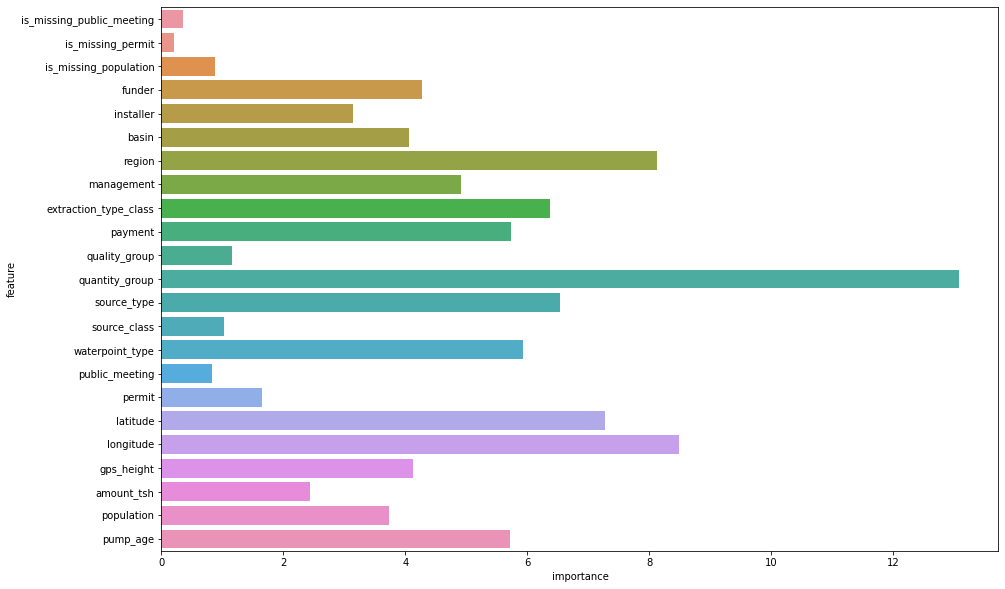

In [128]:
plt.figure(figsize=(15,10))
sns.barplot(y="feature", x="importance", data=feature_importance_df)

In hindsight, it apprears that features `is_missing_public_meeting`, `is_missing_permit`, `is_missing_population`, `quality_group`, `source_class`, and, `public_meeting` are of less importance to the model. It might be possible to remove these to get simplify the model

## Generate Test Predictions

In [ ]:
preds_test = final_pipeline.predict(features_X_test)
preds_series = pd.Series(preds_test, name="status_group")

submission = X_test['id'].to_frame(name='id').merge(preds_series, left_index=True, right_index=True)

submission.to_csv('../submissions/attempt1.csv', index=False)